In [0]:
STORAGE_ACCOUNT_POPE = '[STORAGE]'
SASTOKEN_POPE= '[TOKEN]'

In [0]:
%sh
pip install nltk
pip install --upgrade pip


Requirement already satisfied: nltk in /databricks/python3/lib/python3.8/site-packages (3.6.2)
Requirement already satisfied: regex in /databricks/python3/lib/python3.8/site-packages (from nltk) (2021.7.6)
Requirement already satisfied: click in /databricks/python3/lib/python3.8/site-packages (from nltk) (8.0.1)
Requirement already satisfied: joblib in /databricks/python3/lib/python3.8/site-packages (from nltk) (0.17.0)
Requirement already satisfied: tqdm in /databricks/python3/lib/python3.8/site-packages (from nltk) (4.61.2)
Requirement already satisfied: pip in /databricks/python3/lib/python3.8/site-packages (21.1.3)

In [0]:
%sh
pip install beautifulsoup4

Requirement already satisfied: beautifulsoup4 in /databricks/python3/lib/python3.8/site-packages (4.9.3)
Requirement already satisfied: soupsieve>1.2 in /databricks/python3/lib/python3.8/site-packages (from beautifulsoup4) (2.2.1)

In [0]:
%sh
pip install lxml

Requirement already satisfied: lxml in /databricks/python3/lib/python3.8/site-packages (4.6.3)

In [0]:
#imports necessários
from pyspark.sql import Window
from pyspark.sql.functions import *
import pyspark.sql.functions as Function
from datetime import timedelta
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Row
import datetime
import numpy as np 
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [0]:
# Unmount todos os volumes. 
def delete_mounts(root_mountpoint):
  mnts = dbutils.fs.ls(root_mountpoint + '/')
  for mnt in mnts: 
    try:
      dbutils.fs.unmount(mnt[0])
    except Exception as e:
      if "Directory not mounted" in str(e):
        print(mnt[0] , " - Não estava montado !")
        pass
      else:
        print(e) 


In [0]:
# Função para montar os volumes
def create_mount(nome_container,path_mountpoint,STORAGE_ACCOUNT,SASTOKEN):
  CONTAINER = nome_container
  MOUNTPOINT = path_mountpoint
  SOURCE = "wasbs://{container}@{storage_acct}.blob.core.windows.net/".format(container=CONTAINER, storage_acct=STORAGE_ACCOUNT)
  URI = "fs.azure.sas.{container}.{storage_acct}.blob.core.windows.net".format(container=CONTAINER, storage_acct=STORAGE_ACCOUNT)
  
  try:
    dbutils.fs.mount(
    source=SOURCE,
    mount_point=path_mountpoint,
    extra_configs={URI:SASTOKEN})
  except Exception as e:
    if "Directory already mounted" in str(e):
      print("Já estava montado !")
      pass # Ignore error if already mounted.
    else:
      raise e
  return path_mountpoint

In [0]:
def criar_tabela_temporaria(mount,fonte,owner,tabela,alias, tipo):
  if owner is None:
    path_tabela = mount + '/' + fonte +  '/' + tabela
  else: path_tabela = mount + '/' + fonte +  '/' +  owner + '/' + tabela  
  if tipo == 'parquet':
    df = spark.read.parquet(path_tabela)
  else: df = spark.read.options(header='true').csv(path_tabela)
  df.createOrReplaceTempView(alias)

In [0]:
#monta os containers
TESTE = create_mount('teste','/mnt/teste',STORAGE_ACCOUNT_POPE,SASTOKEN_POPE)

Já estava montado !

In [0]:
TESTE

Out[11]: '/mnt/teste'

In [0]:
dbutils.fs.refreshMounts() 

Mounts successfully refreshed.
Out[12]: True

In [0]:
train_dataset = pd.read_csv("/dbfs/mnt/teste/Corona_NLP_train.csv",encoding="latin")
test_dataset = pd.read_csv("/dbfs/mnt/teste/Corona_NLP_test.csv",encoding="latin")

In [0]:
train_dataset.head()

Out[14]:

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [0]:
test_dataset.head()

Out[15]:

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [0]:
print(train_dataset.columns)
print(test_dataset.columns)

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
 'Sentiment'],
 dtype='object')
Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
 'Sentiment'],
 dtype='object')

In [0]:
train_dataset["Sentiment"].unique()

Out[17]: array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
 'Extremely Positive'], dtype=object)

In [0]:
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train_dataset['class']=train_dataset['Sentiment'].apply(lambda x:classes_def(x))

In [0]:
train_dataset["class"].value_counts(normalize= True)

Out[19]: 2 0.438467
0 0.374128
1 0.187404
Name: class, dtype: float64

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!
Out[20]: True

In [0]:
from bs4 import BeautifulSoup
STOPWORDS = set(stopwords.words('english'))

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(train_dataset['OriginalTweet'].values):
    sentance = re.sub(r'https?://\S+|www\.\S+', r'', sentance) # remove URLS
    sentance = re.sub(r'<.*?>', r'', sentance) # remove HTML
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub(r'\d+', '', sentance).strip() # remove number
    sentance = re.sub(r"[^\w\s\d]","", sentance) # remove pnctuations
    sentance = re.sub(r'@\w+','', sentance) # remove mentions
    sentance = re.sub(r'#\w+','', sentance) # remove hash
    sentance = re.sub(r"\s+"," ", sentance).strip() # remove space
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = ' '.join([e.lower() for e in sentance.split() if e.lower() not in STOPWORDS])
    preprocessed_tweets.append(sentance.strip())

0%| | 0/41157 [00:00<?, ?it/s] 0%| | 84/41157 [00:00<00:56, 726.85it/s] 1%| | 303/41157 [00:00<00:26, 1534.81it/s] 1%|▏ | 527/41157 [00:00<00:22, 1845.64it/s] 2%|▏ | 749/41157 [00:00<00:20, 1987.95it/s] 2%|▏ | 967/41157 [00:00<00:19, 2054.28it/s] 3%|▎ | 1197/41157 [00:00<00:18, 2136.58it/s] 3%|▎ | 1429/41157 [00:00<00:18, 2194.95it/s] 4%|▍ | 1650/41157 [00:00<00:18, 2192.73it/s] 5%|▍ | 1874/41157 [00:00<00:17, 2205.85it/s] 5%|▌ | 2104/41157 [00:01<00:17, 2232.22it/s] 6%|▌ | 2328/41157 [00:01<00:17, 2209.72it/s] 6%|▌ | 2560/41157 [00:01<00:17, 2240.47it/s] 7%|▋ | 2790/41157 [00:01<00:16, 2256.95it/s] 7%|▋ | 3026/41157 [00:01<00:16, 2287.04it/s] 8%|▊ | 3260/41157 [00:01<00:16, 2301.25it/s] 8%|▊ | 3493/41157 [00:01<00:16, 2308.02it/s] 9%|▉ | 3724/41157 [00:01<00:16, 2296.64it/s] 10%|▉ | 3959/41157 [00:01<00:16, 2311.32it/s] 10%|█ | 4196/41157 [00:01<00:15, 2327.24it/s] 11%|█ | 4431/41157 [00:02<00:15, 2328.90it/s] 11%|█▏ | 4664/41157 [00:02<00:15, 2316.65it/s] 12%|█▏ | 4896/41157 [00:02<00:16, 2239.57it/s] 12%|█▏ | 5125/41157 [00:02<00:15, 2252.63it/s] 13%|█▎ | 5357/41157 [00:02<00:15, 2272.28it/s] 14%|█▎ | 5585/41157 [00:02<00:17, 2074.68it/s] 14%|█▍ | 5814/41157 [00:02<00:16, 2132.71it/s] 15%|█▍ | 6038/41157 [00:02<00:16, 2162.07it/s] 15%|█▌ | 6263/41157 [00:02<00:15, 2186.72it/s] 16%|█▌ | 6491/41157 [00:02<00:15, 2212.80it/s] 16%|█▋ | 6720/41157 [00:03<00:15, 2233.05it/s] 17%|█▋ | 6946/41157 [00:03<00:15, 2228.32it/s] 17%|█▋ | 7170/41157 [00:03<00:15, 2198.24it/s] 18%|█▊ | 7395/41157 [00:03<00:15, 2210.68it/s] 19%|█▊ | 7620/41157 [00:03<00:15, 2220.09it/s] 19%|█▉ | 7843/41157 [00:03<00:15, 2216.90it/s] 20%|█▉ | 8065/41157 [00:03<00:14, 2217.26it/s] 20%|██ | 8293/41157 [00:03<00:14, 2233.87it/s] 21%|██ | 8517/41157 [00:03<00:14, 2228.99it/s] 21%|██ | 8740/41157 [00:03<00:14, 2200.27it/s] 22%|██▏ | 8963/41157 [00:04<00:14, 2207.85it/s] 22%|██▏ | 9188/41157 [00:04<00:14, 2216.55it/s] 23%|██▎ | 9410/41157 [00:04<00:14, 2207.46it/s] 23%|██▎ | 9635/41157 [00:04<00:14, 2217.69it/s] 24%|██▍ | 9857/41157 [00:04<00:14, 2191.38it/s] 24%|██▍ | 10077/41157 [00:04<00:14, 2183.24it/s] 25%|██▌ | 10298/41157 [00:04<00:14, 2190.25it/s] 26%|██▌ | 10518/41157 [00:04<00:14, 2182.83it/s] 26%|██▌ | 10737/41157 [00:04<00:13, 2183.22it/s] 27%|██▋ | 10957/41157 [00:04<00:13, 2188.11it/s] 27%|██▋ | 11176/41157 [00:05<00:13, 2142.35it/s] 28%|██▊ | 11391/41157 [00:05<00:14, 2112.62it/s] 28%|██▊ | 11603/41157 [00:05<00:14, 2107.59it/s] 29%|██▊ | 11816/41157 [00:05<00:13, 2112.01it/s] 29%|██▉ | 12028/41157 [00:05<00:14, 2066.18it/s] 30%|██▉ | 12242/41157 [00:05<00:13, 2087.35it/s] 30%|███ | 12465/41157 [00:05<00:13, 2128.19it/s] 31%|███ | 12688/41157 [00:05<00:13, 2155.68it/s] 31%|███▏ | 12904/41157 [00:05<00:13, 2087.59it/s] 32%|███▏ | 13114/41157 [00:06<00:13, 2045.52it/s] 32%|███▏ | 13345/41157 [00:06<00:13, 2120.42it/s] 33%|███▎ | 13561/41157 [00:06<00:12, 2127.87it/s] 33%|███▎ | 13775/41157 [00:06<00:13, 2020.46it/s] 34%|███▍ | 13988/41157 [00:06<00:13, 2048.95it/s] 35%|███▍ | 14209/41157 [00:06<00:12, 2093.57it/s] 35%|███▌ | 14420/41157 [00:06<00:12, 2096.01it/s] 36%|███▌ | 14646/41157 [00:06<00:12, 2120.46it/s] 36%|███▌ | 14876/41157 [00:06<00:12, 2172.26it/s] 37%|███▋ | 15102/41157 [00:06<00:11, 2196.93it/s] 37%|███▋ | 15325/41157 [00:07<00:11, 2205.51it/s] 38%|███▊ | 15554/41157 [00:07<00:11, 2228.86it/s] 38%|███▊ | 15778/41157 [00:07<00:11, 2182.31it/s] 39%|███▉ | 16000/41157 [00:07<00:11, 2192.54it/s] 39%|███▉ | 16224/41157 [00:07<00:11, 2205.75it/s] 40%|███▉ | 16453/41157 [00:07<00:11, 2228.37it/s] 41%|████ | 16688/41157 [00:07<00:10, 2263.68it/s] 41%|████ | 16921/41157 [00:07<00:10, 2282.67it/s] 42%|████▏ | 17152/41157 [00:07<00:10, 2289.54it/s] 42%|████▏ | 17386/41157 [00:07<00:10, 2303.92it/s] 43%|████▎ | 17617/41157 [00:08<00:10, 2279.87it/s] 43%|████▎ | 17846/41157 [00:08<00:10, 2257.70it/s] 44%|████▍ | 18072/41157 [00:08<00:10, 2145.87it/s] 44%|████▍ | 18288/

###TF-IDF###

In [0]:
tf_idf_vect = TfidfVectorizer(min_df=10)
tf_idf_vect.fit(preprocessed_tweets)
print("alguns recursos de exemplo (palavras exclusivas no corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_tweets)
print("o tipo de vetorizador de contagem ",type(final_tf_idf))
print("a forma do vetorizador TFIDF de texto ",final_tf_idf.get_shape())
print("o número de palavras únicas, incluindo unigramas e bigramas ", final_tf_idf.get_shape()[1])

alguns recursos de exemplo (palavras exclusivas no corpus) ['abc', 'abcnews', 'ability', 'able', 'abroad', 'absence', 'absolute', 'absolutely', 'absurd', 'abt']
==================================================
o tipo de vetorizador de contagem <class 'scipy.sparse.csr.csr_matrix'>
a forma do vetorizador TFIDF de texto (41157, 6611)
o número de palavras únicas, incluindo unigramas e bigramas 6611

In [0]:
X = final_tf_idf
y = train_dataset["class"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X.tocsr(), y, test_size= 0.33, stratify=y,  random_state=42)

###MultinomialNB###

In [0]:
grid_params ={'alpha':[10**x for x in range(-4,4)]}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

MultinomialNB_model = GridSearchCV(MultinomialNB(),grid_params,
                     scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
MultinomialNB_model.fit(X_train, y_train)

Out[26]: GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
 param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
 return_train_score=True, scoring='accuracy')

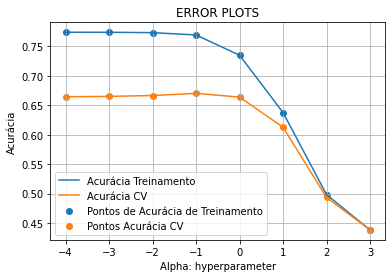

MultinomialNB(alpha=0.1)

In [0]:
results = pd.DataFrame.from_dict(MultinomialNB_model.cv_results_)
results = results.sort_values(['param_alpha'])

plt.plot(alpha_log, results["mean_train_score"], label='Acurácia Treinamento')
plt.plot(alpha_log, results["mean_test_score"].values, label='Acurácia CV')

plt.scatter(alpha_log, results["mean_train_score"].values, label='Pontos de Acurácia de Treinamento')
plt.scatter(alpha_log, results["mean_test_score"].values, label='Pontos Acurácia CV')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("Acurácia")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
print(MultinomialNB_model.best_estimator_)

Accuracy: 0.6749374171697835
Out[28]:

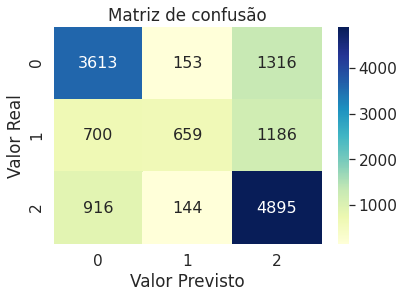

Text(25.5, 0.5, 'Valor Real')

In [0]:
MultinomialNB_model = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
MultinomialNB_model.fit(X_train,y_train)

y_pred = MultinomialNB_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Matriz de confusão")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")

In [0]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

precision recall f1-score support

 1 0.69 0.71 0.70 5082
 2 0.69 0.26 0.38 2545
 0 0.66 0.82 0.73 5955

 accuracy 0.67 13582
 macro avg 0.68 0.60 0.60 13582
weighted avg 0.68 0.67 0.65 13582

###Random Forest###

In [0]:
max_depth = [1,5,10,50]
n_estimators = [5,10,100,500]
grid_params ={'max_depth':max_depth,'n_estimators':n_estimators}

RandomFoest_model = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_params,
                  scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
RandomFoest_model.fit(X_train, y_train)

results = pd.DataFrame.from_dict(RandomFoest_model.cv_results_)
print(RandomFoest_model.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=500)

Out[31]:

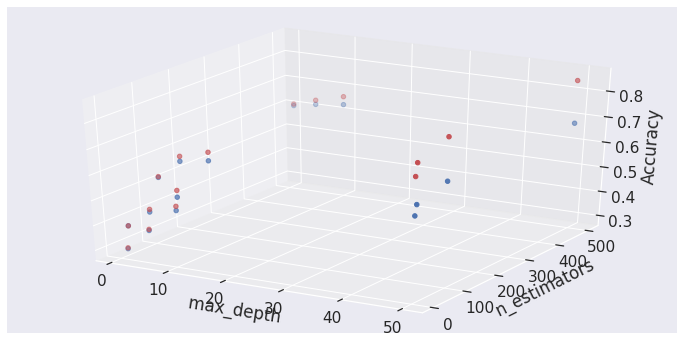

Text(0.5, 0, 'Accuracy')

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

max_depth = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
n_estimators = [5,10,100,500,5,10,100,500,5,10,100,500,5,10,100,500]
mean_train_score = list(results["mean_train_score"].values)
mean_test_score = list(results["mean_test_score"].values)

fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(max_depth, n_estimators, mean_train_score, c='r', marker='o')
ax.scatter(max_depth, n_estimators, mean_test_score, c='b', marker='o')

ax.set_xlabel('max_depth ')
ax.set_ylabel('n_estimators')
ax.set_zlabel('Accuracy')

Accuracy: 0.6867177146222943
Out[32]:

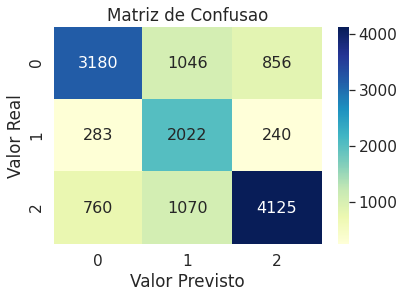

Text(25.5, 0.5, 'Valor Real')

In [0]:
RandomFoest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
RandomFoest_model.fit(X_train,y_train)

y_pred = RandomFoest_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Matriz de Confusao")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")

In [0]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

precision recall f1-score support

 1 0.75 0.63 0.68 5082
 2 0.49 0.79 0.61 2545
 0 0.79 0.69 0.74 5955

 accuracy 0.69 13582
 macro avg 0.68 0.70 0.68 13582
weighted avg 0.72 0.69 0.69 13582

###SGD Classifier###

In [0]:
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
grid_params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]

SGDClassifier_model = GridSearchCV(SGDClassifier(class_weight= 'balanced'), grid_params,
                     scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
SGDClassifier_model.fit(X_train, y_train)

results = pd.DataFrame.from_dict(SGDClassifier_model.cv_results_)
results = results.sort_values(['param_alpha'])

print(SGDClassifier_model.best_estimator_)

SGDClassifier(class_weight='balanced', penalty='l1')

Accuracy: 0.7738919157708732
Out[25]:

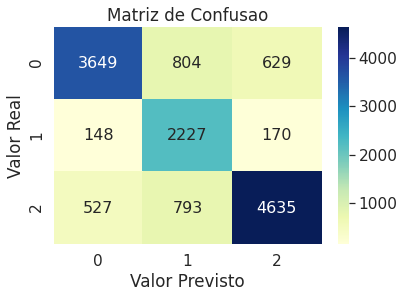

Text(25.5, 0.5, 'Valor Real')

In [0]:
SGDClassifier_model = SGDClassifier(class_weight='balanced', penalty='l1')
SGDClassifier_model.fit(X_train,y_train)

y_pred = SGDClassifier_model.predict(X_test)
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm,index=[0,1,2],columns=[0,1,2])
print("Accuracy:",accuracy_score(y_test, y_pred))

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Matriz de Confusao")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")

In [0]:
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_dataset['class'].unique()))

precision recall f1-score support

 1 0.84 0.72 0.78 5082
 2 0.58 0.88 0.70 2545
 0 0.85 0.78 0.81 5955

 accuracy 0.77 13582
 macro avg 0.76 0.79 0.76 13582
weighted avg 0.80 0.77 0.78 13582

In [0]:
print(test_dataset,y_pred)


UserName ... Sentiment
0 1 ... Extremely Negative
1 2 ... Positive
2 3 ... Extremely Positive
3 4 ... Negative
4 5 ... Neutral
... ... ... ...
3793 3794 ... Positive
3794 3795 ... Negative
3795 3796 ... Neutral
3796 3797 ... Extremely Negative
3797 3798 ... Extremely Positive

[3798 rows x 6 columns] ['1' '2' '0' ... '1' '0' '2']

In [0]:
new_series = pd.Series(y_pred)

df= pd.merge(test_dataset, new_series.rename('predicao'), left_index=True, right_index=True)

In [0]:
df


Out[29]:

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,predicao
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,1
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,2
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,0
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,2
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,0
...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,2
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,0
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,2
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative,0


In [0]:
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

In [0]:
spark_df = pandas_to_spark(df)

In [0]:
spark_df.write.parquet(TESTE+'/resultado.parquet')